In [338]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
import itertools

In [414]:
def get_dataset(url, country):
    raw_dataset = pd.read_csv(url)
    df = raw_dataset[raw_dataset["Country"]==country].reset_index(drop=True) 
    df.insert(5, 'Day', range(1, 1 + len(df)))
    for i in range(0, len(df)):
        df.loc[i, 'Active']    = df.loc[i, 'Confirmed'] - df.loc[i, 'Recovered']
        df.loc[i, 'New_Cases'] = 0 if i == 0 else df.loc[i, 'Confirmed'] - df.loc[i-1, 'Confirmed']
        df.loc[i, 'Spread_Rate'] = None if i == 0 else df.loc[i, 'Confirmed'] / df.loc[i-1, 'Confirmed']
        df.loc[i, 'New_Cases_Diff'] = 0 if i == 0 else df.loc[i, 'New_Cases'] - df.loc[i-1, 'New_Cases']
        df.loc[i, 'Spread_Rate_Diff'] = (0 if i == 0 else df.loc[i, 'Spread_Rate'] - df.loc[i-1, 'Spread_Rate']) * 100
    return df[['Country', 'Date','Day','Confirmed','Recovered','Deaths','Active','New_Cases','New_Cases_Diff','Spread_Rate','Spread_Rate_Diff']].reset_index(drop=True) 


In [340]:
def get_time_series_dataset(ds, column, train_cnt):
    ds['Date'] = pd.to_datetime(ds['Date'], format='%Y-%m-%d')
    return ds[['Date', column]].set_index('Date').tail(train_cnt) 

In [341]:
def get_arima_order(train):
    p=d=q=range(0,5)
    pdq = list(itertools.product(p,d,q))
    import warnings
    warnings.filterwarnings('ignore')
    d={}
    for param in pdq:
        try:
            model_arima = ARIMA(train,order=param)
            model_arima_fit = model_arima.fit()
            d[param]=model_arima_fit.aic
        except:
            continue
    return min(d, key=lambda k: d[k]);

In [342]:
def get_model(ds):
    X = ds.values
#     X = X.astype('float32')
    order = get_arima_order(X)
#     print("pdq order is "+str(order))    
    model_arima = ARIMA(X,order)
    model_arima_fit = model_arima.fit()
#     print("AIC score is "+str(model_arima_fit.aic))    
    return model_arima_fit

In [343]:
## Function to find the prediction when the curve starts flattening
def find_flatten_point(model, steps, threshold):
    predictions = model.forecast(steps)[0]
    last_prediction = predictions[len(predictions)-1]
    last_before_prediction = predictions[len(predictions)-2]
    if(last_prediction <= last_before_prediction):
        print("achieved flatten the curve at "+str(steps)+" step and the value is "+str(last_prediction))
        return steps
    elif (last_prediction > last_before_prediction and steps >= threshold):
        print('Threashold reached.. Flatten the curve never achieved in the prediction')
        return None
    else:
        return find_flatten_point(model, steps+1, threshold)

In [344]:
##  Function to find when the prediction goes below zero
def get_last_prediction(model, steps):
    predictions = model.forecast(steps)[0]
    return predictions[-1]

def find_zero_case(model, steps, threshold):
    last_value = get_last_prediction(model, steps)
    if(last_value < 0):
#         print("achieved: "+str(last_value)+" at "+str(steps)+" step")
        return steps
    elif (last_value > 0 and steps >= threshold):
#         print('Threashold reached.. Predictions were never less than zero')
        return None
    else:
        return find_zero_case(model, steps + 1, threshold)

In [345]:
def get_flatten_point_pattern(ds, column, train_start, train_end, prediction_threshold):
    if(train_start > train_end):
        return
    time_series_ds = get_time_series_dataset(ds, column, train_cnt=train_start)
    model = get_model(time_series_ds)
    prediction = find_zero_case(model, 5, prediction_threshold)
    print("<<< Zero Case Prediction for "+str(train_start)+" cnt is "+str(prediction)+" >>>")
    train_start = train_start + 1
    return get_flatten_point_pattern(ds, column, train_start, train_end, prediction_threshold)

In [412]:
url="/Users/laya/Desktop/work/projects/data/country/covid-19/data/countries-aggregated.csv"
train_cnt = 15
canada_dataset = get_dataset(url, 'Canada')

In [406]:
canada_ts_dataset = get_time_series_dataset(canada_dataset, column='Active', train_cnt=15)
# model = get_model(canada_ts_dataset)
# result = find_zero_case(model, 5, 150)
# result

In [413]:
canada_dataset.tail(15)

,Country,Date,Day,Confirmed,Recovered,Deaths,Active,New_Cases,New_Cases_Diff,Spread_Rate,Spread_Rate_Diff
78,Canada,2020-04-09,79,20654,5162,503,15492.0,1513.0,244.0,1.079045,0.804006
79,Canada,2020-04-10,80,22059,5855,557,16204.0,1405.0,-108.0,1.068026,-1.101942
80,Canada,2020-04-11,81,23316,6589,654,16727.0,1257.0,-148.0,1.056984,-1.104202
81,Canada,2020-04-12,82,24298,7123,714,17175.0,982.0,-275.0,1.042117,-1.486654
82,Canada,2020-04-13,83,25679,7758,779,17921.0,1381.0,399.0,1.056836,1.471895
83,Canada,2020-04-14,84,27034,8210,899,18824.0,1355.0,-26.0,1.052767,-0.406910
84,Canada,2020-04-15,85,28208,8966,1006,19242.0,1174.0,-181.0,1.043427,-0.934006
85,Canada,2020-04-16,86,30808,9698,1257,21110.0,2600.0,1426.0,1.092172,4.874564
86,Canada,2020-04-17,87,32813,10545,1354,22268.0,2005.0,-595.0,1.065080,-2.709193
87,Canada,2020-04-18,88,34355,10964,1399,23391.0,1542.0,-463.0,1.046994,-1.808693


In [384]:
# find_flatten_point(model, 10, 500)
get_flatten_point_pattern(canada_dataset, column='New_Cases', train_start=5, train_end=20, prediction_threshold=250)

<<< Zero Case Prediction for 5 cnt is None >>>
<<< Zero Case Prediction for 6 cnt is 6 >>>
<<< Zero Case Prediction for 7 cnt is None >>>
<<< Zero Case Prediction for 8 cnt is None >>>
<<< Zero Case Prediction for 9 cnt is 5 >>>
<<< Zero Case Prediction for 10 cnt is 21 >>>
<<< Zero Case Prediction for 11 cnt is 9 >>>
<<< Zero Case Prediction for 12 cnt is 13 >>>
<<< Zero Case Prediction for 13 cnt is 16 >>>
<<< Zero Case Prediction for 14 cnt is 26 >>>
<<< Zero Case Prediction for 15 cnt is 59 >>>
<<< Zero Case Prediction for 16 cnt is 236 >>>
<<< Zero Case Prediction for 17 cnt is None >>>
<<< Zero Case Prediction for 18 cnt is 99 >>>
<<< Zero Case Prediction for 19 cnt is None >>>
<<< Zero Case Prediction for 20 cnt is None >>>


In [372]:
# plot_graph(canada_dataset, 'Day', 'Confirmed', 'Canada Curve')
# plot_graph(canada_dataset, 'Day', 'New_Cases', 'Canada Curve')
# canada_ts_dataset.plot()
canada_ts_dataset

,Spread_Rate
Date,
2020-04-09,1.079045
2020-04-10,1.068026
2020-04-11,1.056984
2020-04-12,1.042117
2020-04-13,1.056836
2020-04-14,1.052767
2020-04-15,1.043427
2020-04-16,1.092172
2020-04-17,1.065080


In [377]:
canada_ts_dataset = get_time_series_dataset(canada_dataset, column='New_Cases', train_cnt=15)
X = canada_ts_dataset.values.astype('float32')
order=get_arima_order(X)
order

(0, 2, 1)

In [378]:
model_arima = ARIMA(X, order)
model_arima_fit = model_arima.fit()

In [450]:
predictions_all=model_arima_fit.forecast(steps=150)[0]

In [453]:
predictions = []
negative_cnt = 0
for i in range(0, len(predictions_all)):
    if (negative_cnt > 25):
        break
    if (predictions_all[i] < 0):
        negative_cnt = negative_cnt + 1
    predictions.append(predictions_all[i])

In [460]:
ds = canada_dataset.tail(1).reset_index(drop=True)[['Country', 'Date', 'Day','Confirmed','New_Cases']]
ds.loc[0, 'Day'] = 0
for i in range(0, len(predictions)):
    day =  ds.Day[-1:].values[0] + 1
    new_cases = predictions[i]
    confirmed = int(ds.Confirmed[-1:].values[0] + new_cases)
    date = datetime.strftime(datetime.strptime(ds.Date[-1:].values[0] , '%Y-%m-%d') + timedelta(days=1), '%Y-%m-%d')
    ds = ds.append({'Country': 'Canada', 'Date' : date, 'Day': day, 'Confirmed': confirmed, 'New_Cases': new_cases} , ignore_index=True)

ds['New_Cases'] = ds['New_Cases'].astype(int)    
ds.size

425

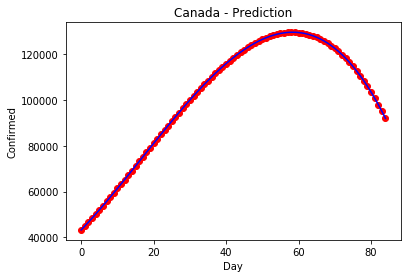

In [461]:
x=ds.Day.values
y=ds.Confirmed.values
plt.scatter(x, y, color='red')
plt.plot(x, y, color='blue')
plt.title('Canada - Prediction')
plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.show()

In [442]:
x[0]
y[0]

20654